In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import cv2
import albumentations as A

# Load dataset

In [2]:
path = "D:/LFPW"

In [3]:
train_image = np.load(os.path.join(path,"train_image.npy"), allow_pickle=True)
train_annotation = np.load(os.path.join(path,"train_annotation.npy"), allow_pickle=True)
test_image = np.load(os.path.join(path,"test_image.npy"), allow_pickle=True)
test_annotation = np.load(os.path.join(path,"test_annotation.npy"), allow_pickle=True)

# Preprocess image

In [5]:
def make_dataset_float(X, size):
    img_data = []
    for image in X:
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_NEAREST)
        image = image.astype('float32')
        image /= 255 
        img_data.append(image)
    return np.array(img_data)

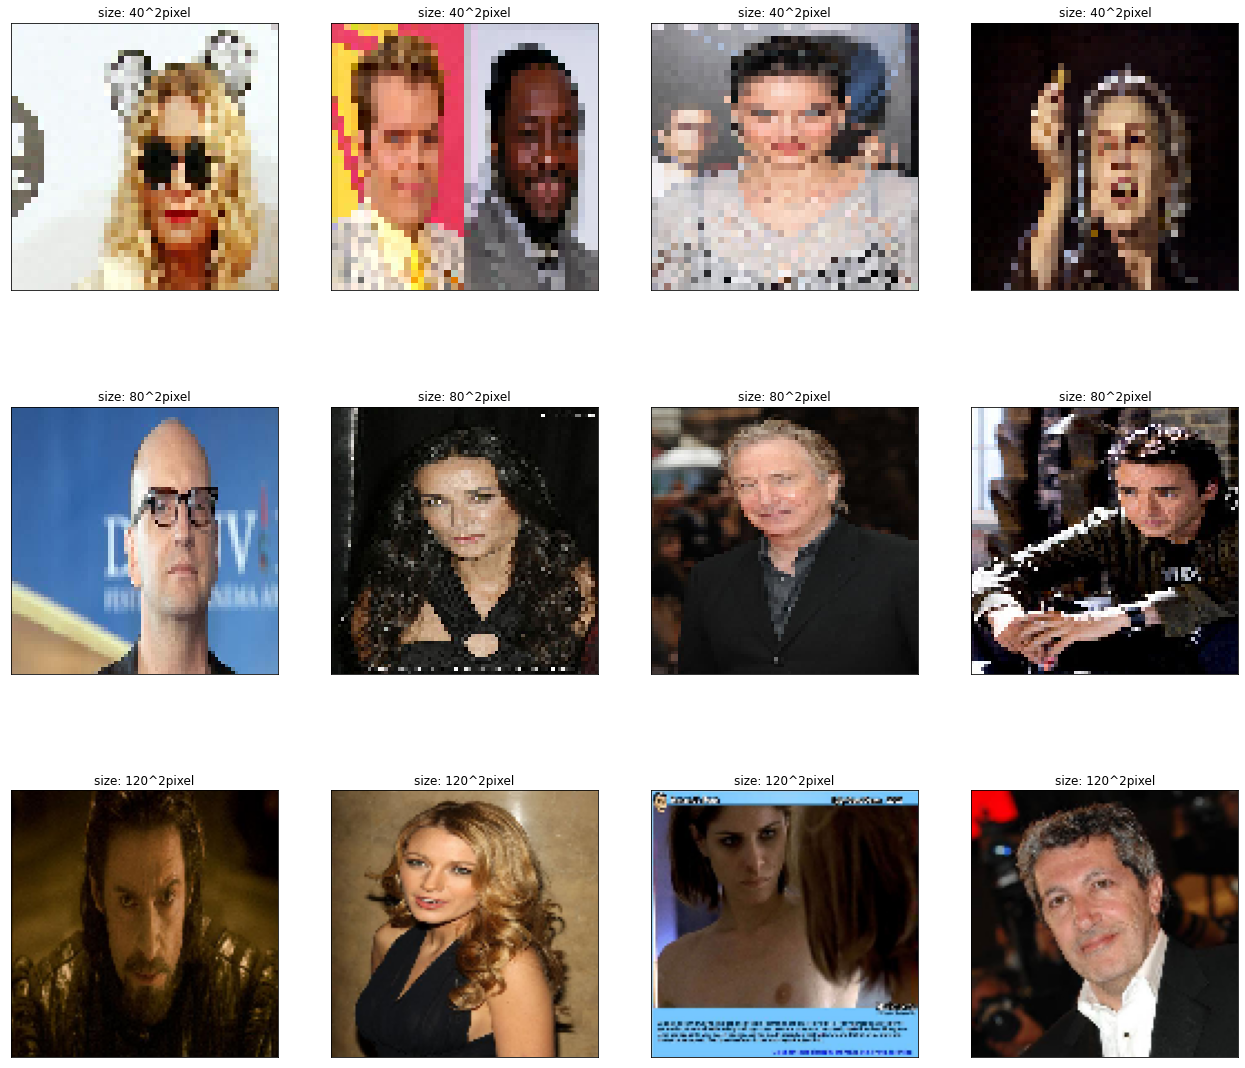

In [6]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    dataset = make_dataset_float(test_image, (j+1)*40)
    index = np.random.randint(len(dataset))
    ax[j][k].imshow(dataset[index])
    ax[j][k].set_title("size: {}^2pixel".format((j+1)*40))
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])    

# Make dataset for model

In [9]:
train_keypoint=[]
for i in train_annotation:
    index=0
    for j in range(0, len(train_annotation[0]), 3):
        index+=1
        if index > 36 and index < 49:
            train_keypoint.append([i[j], i[j+1]])

In [10]:
test_keypoint=[]
for i in test_annotation:
    index=0
    for j in range(0, len(test_annotation[0]), 3):
        index+=1
        if index > 36 and index < 49:
            test_keypoint.append([i[j], i[j+1]])

In [11]:
train_keypoint = np.reshape(train_keypoint, (train_image.shape[0], 12, 2))
test_keypoint = np.reshape(test_keypoint, (test_image.shape[0], 12, 2))

In [203]:
transform_crop = A.Compose([
    A.Resize(100, 100, interpolation=cv2.INTER_AREA),
    A.RandomCrop(80, 80),
    A.HorizontalFlip(p=1), 
    A.Cutout(num_holes=7, max_h_size=25, max_w_size=25,p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.7, 0.7), contrast_limit=[-0.7, 0.7])
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

transform_resize = A.Compose([
    A.Resize(80, 80, interpolation=cv2.INTER_AREA),
], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\albumentations\augmentations\transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [204]:
X_train = []
y_train = []
for index in range(5):
    for i in range(len(train_image)):
        transformed = transform_crop(image = train_image[i], keypoints = train_keypoint[i])
        X_train.append(transformed["image"])
        y_train.append(transformed["keypoints"])    

In [205]:
X_test = []
y_test = []
for i in range(len(test_image)):
    transformed = transform_resize(image = test_image[i], keypoints = test_keypoint[i])
    X_test.append(transformed["image"])
    y_test.append(transformed["keypoints"])  

Example of augmented images

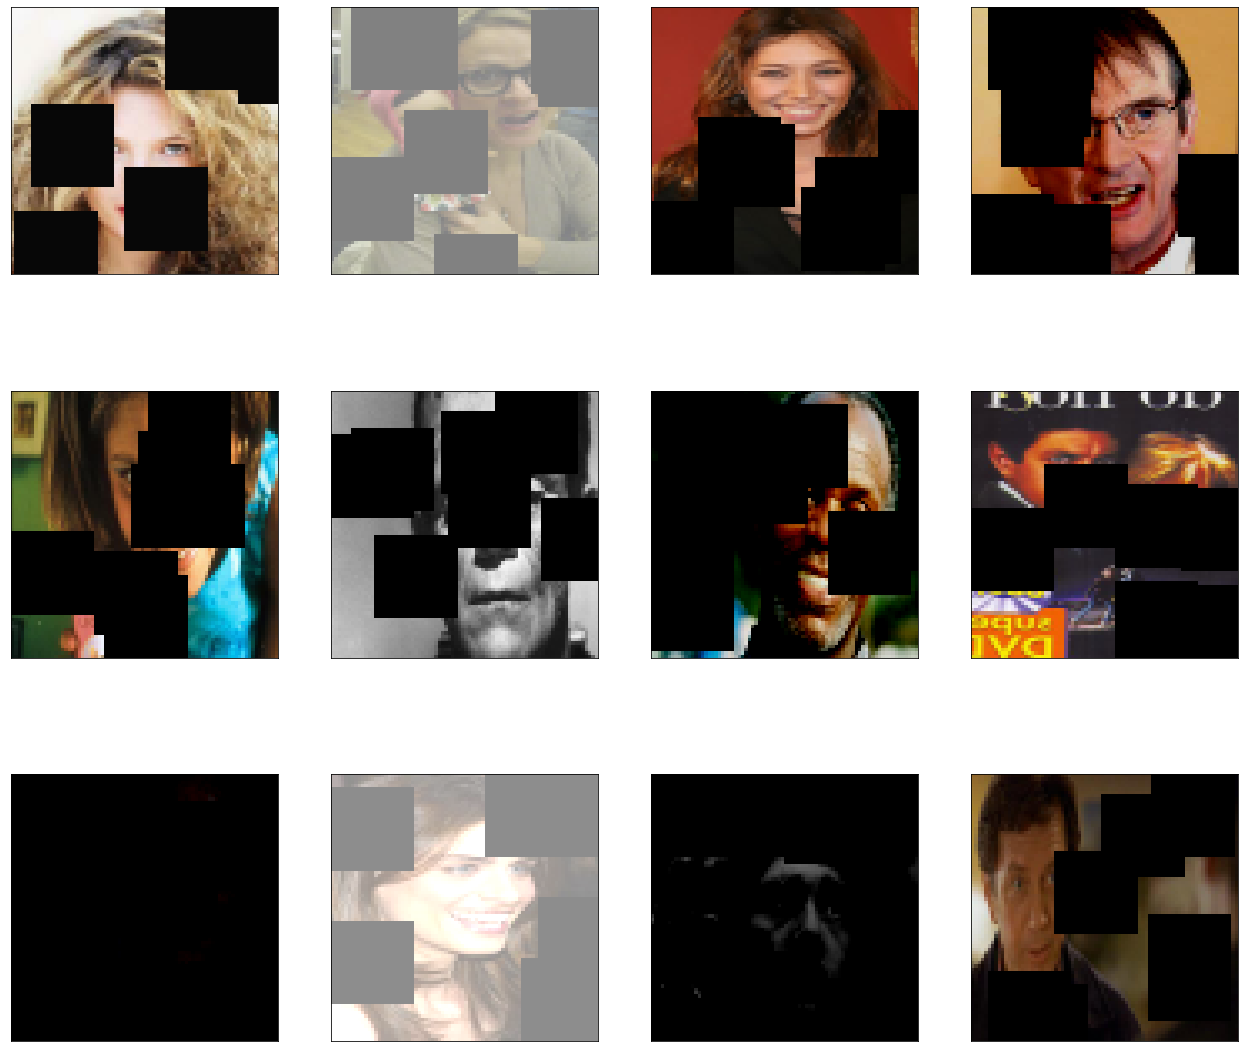

In [206]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    ax[j][k].imshow(X_train[index])
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])    

In [207]:
X_train = np.array(X_train) 
y_train = np.reshape(y_train, (X_train.shape[0], 24))
X_test = np.array(X_test) 
y_test = np.reshape(y_test, (X_test.shape[0], 24))

In [208]:
Input = keras.Input(shape=(X_train.shape[1], X_train.shape[2], 3))
x = keras.layers.Conv2D(32, 3, 2, "same", activation="relu", kernel_initializer="he_normal")(Input)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2D(64, 3, 1, "same", activation="relu", kernel_initializer="he_normal")(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2D(96, 3, 1, "same", activation="relu", kernel_initializer="he_normal")(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2D(128, 3, 1, "same", activation="relu", kernel_initializer="he_normal")(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2D(256, 3, 1, "same", activation="relu", kernel_initializer="he_normal")(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(10000, activation="relu")(x)

# x = keras.layers.Dense(1024, activation="relu")(x)
# x = keras.layers.BatchNormalization()(x)
Output = keras.layers.Dense(24, activation="linear")(x)

model = keras.Model(inputs = Input, outputs = Output)

In [209]:
model.compile(loss=keras.losses.mse, optimizer="adam", metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=20)

Epoch 1/20
123/123 [==============================] - 7s 49ms/step - loss: 503.8761 - mse: 503.8761 - val_loss: 1059.3359 - val_mse: 1059.3359
Epoch 2/20
123/123 [==============================] - 6s 48ms/step - loss: 573.0413 - mse: 573.0413 - val_loss: 838.3504 - val_mse: 838.3504
Epoch 3/20
123/123 [==============================] - 6s 47ms/step - loss: 603.3073 - mse: 603.3073 - val_loss: 524.5729 - val_mse: 524.5729A - ETA: 0s - loss: 603.3246 - mse: 603.324
Epoch 4/20
123/123 [==============================] - 6s 48ms/step - loss: 393.2805 - mse: 393.2805 - val_loss: 688.7983 - val_mse: 688.7983 2s - loss: 435 - ETA: 0s - loss: 394.0901 - mse: 39
Epoch 5/20
123/123 [==============================] - 6s 48ms/step - loss: 277.9180 - mse: 277.9180 - val_loss: 364.4021 - val_mse: 364.4021ETA: 0s - loss: 288.2064 - m
Epoch 6/20
123/123 [==============================] - 6s 48ms/step - loss: 242.1035 - mse: 242.1035 - val_loss: 366.0866 - val_mse: 366.086625 - ETA: 1s - loss: 246.9189 

# Visualize model's prediction

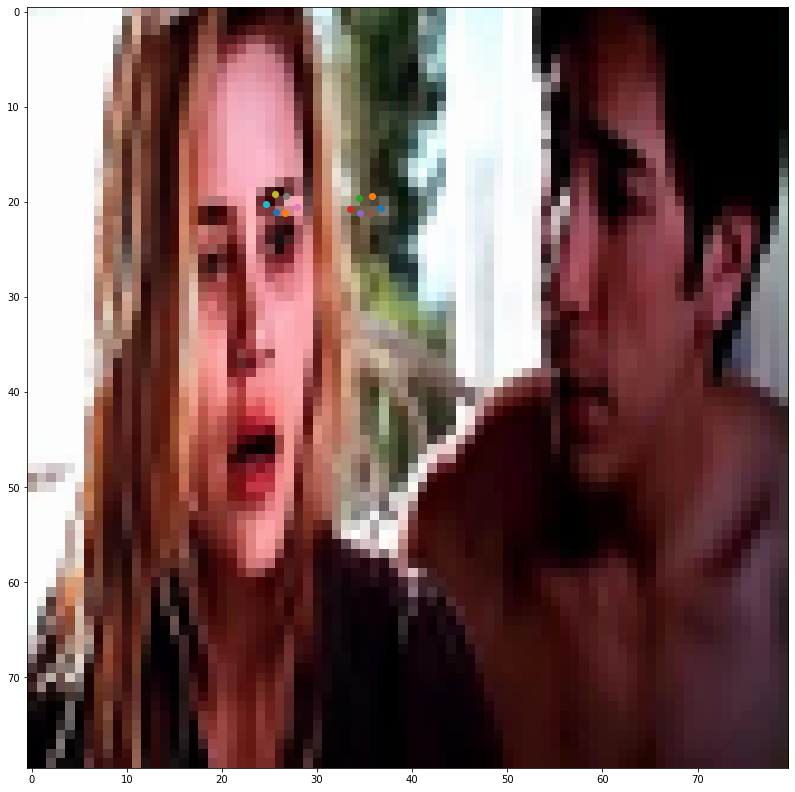

In [226]:
index = 10
fig, ax = plt.subplots(figsize=(14, 14))
pred = model.predict(np.array([X_test[index]]))[0]
ax.imshow(X_test[index])
for i in range(0, 24, 2):
    ax.scatter(pred[i], pred[i+1])

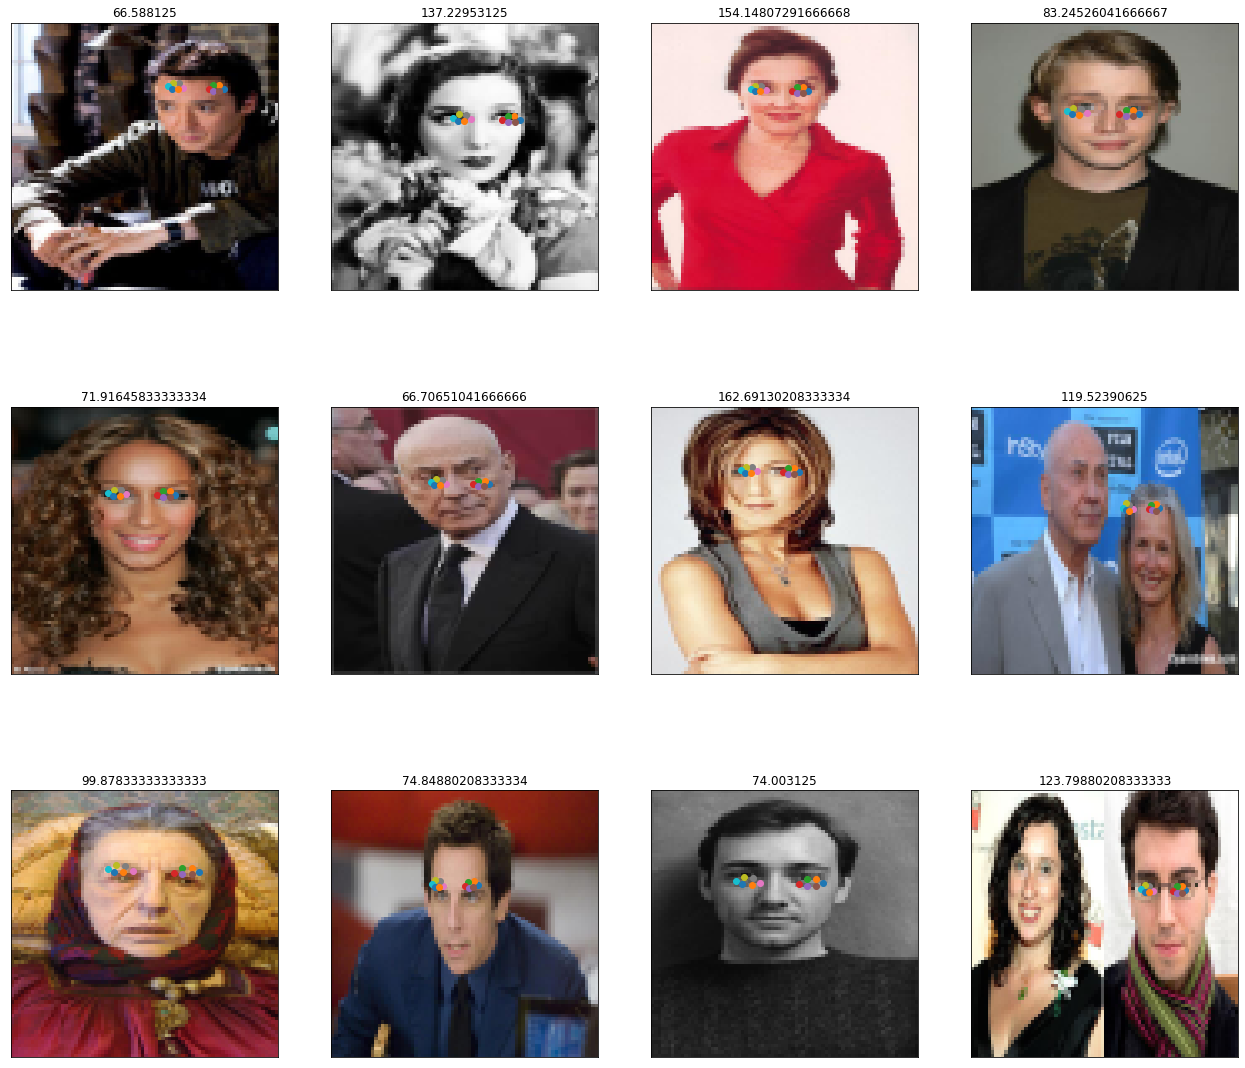

In [227]:
fig, ax = plt.subplots(3, 4, figsize=(22, 20))
for i in range(12):
    j = i//4
    k = i%4
    index = np.random.randint(len(dataset))
    pred = model.predict(np.array([X_test[index]]))[0]
    ax[j][k].imshow(X_test[index])
    ax[j][k].set_title(X_test[index].mean())
    ax[j][k].xaxis.set_ticks([])
    ax[j][k].yaxis.set_ticks([])   
    for i in range(0, 24, 2):
        ax[j][k].scatter(pred[i], pred[i+1])

# Using trasnfer learning

In [215]:
transfer_model = keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3),
                                                  )

In [216]:
x = transfer_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(24, activation="linear", kernel_initializer="he_normal")(x)

In [217]:
model = keras.Model(inputs=transfer_model.input, outputs=predictions)

In [218]:
for layer in transfer_model.layers:
    layer.trainable = False

In [219]:
model.compile(loss=keras.losses.mse, optimizer="adam", metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5)

Epoch 1/5
123/123 [==============================] - 11s 40ms/step - loss: 770.9998 - mse: 770.9998 - val_loss: 692.1512 - val_mse: 692.1512
Epoch 2/5
123/123 [==============================] - 4s 29ms/step - loss: 301.4925 - mse: 301.4925 - val_loss: 473.8168 - val_mse: 473.8168
Epoch 3/5
123/123 [==============================] - 4s 29ms/step - loss: 211.8712 - mse: 211.8712 - val_loss: 415.9212 - val_mse: 415.9212
Epoch 4/5
123/123 [==============================] - 4s 29ms/step - loss: 193.8561 - mse: 193.8561 - val_loss: 391.0286 - val_mse: 391.0286
Epoch 5/5
123/123 [==============================] - 4s 30ms/step - loss: 187.1928 - mse: 187.1928 - val_loss: 376.3758 - val_mse: 376.3758


In [223]:
for layer in model.layers[:49]:
   layer.trainable = False
for layer in model.layers[49:]:
   layer.trainable = True

In [225]:
model.compile(loss=keras.losses.mse, optimizer="adam", metrics="mse")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=15)

Epoch 1/15
123/123 [==============================] - 18s 82ms/step - loss: 223.6449 - mse: 223.6449 - val_loss: 179.4083 - val_mse: 179.4083
Epoch 2/15
123/123 [==============================] - 9s 71ms/step - loss: 108.1893 - mse: 108.1893 - val_loss: 193.0827 - val_mse: 193.0827
Epoch 3/15
123/123 [==============================] - 9s 71ms/step - loss: 69.4834 - mse: 69.4834 - val_loss: 199.2906 - val_mse: 199.2906
Epoch 4/15
123/123 [==============================] - 9s 72ms/step - loss: 48.3007 - mse: 48.3007 - val_loss: 191.1077 - val_mse: 191.1077
Epoch 5/15
123/123 [==============================] - 9s 72ms/step - loss: 39.5934 - mse: 39.5934 - val_loss: 171.1818 - val_mse: 171.1818ETA: 1s - 
Epoch 6/15
123/123 [==============================] - 9s 72ms/step - loss: 46.4199 - mse: 46.4199 - val_loss: 174.4575 - val_mse: 174.4575
Epoch 7/15
123/123 [==============================] - 9s 71ms/step - loss: 31.3391 - mse: 31.3391 - val_loss: 153.9369 - val_mse: 153.9369
Epoch 8/15
1